# Driven RLC circuit

member: Mingzhu Liu

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
V0 = 120 # max voltage

# Values of the components
L = 0.337
R = 16

omega = R / L

XL = omega * L

# Choose capacitance based on phasor diagram:
# resonance
XC_resonance = XL

# current lags 30 degrees
XC_lag = XL - np.tan(np.pi / 6) * R

# current leads 30 degrees
XC_lead = XL + np.tan(np.pi / 6) * R


In [3]:
class Circuit():
    '''Define a driven RLC Circuit, and use methods to perform the time integration'''
    def __init__(self, R = R, L = L, XL = XL, XC = XL, V = V0, omega = omega, num_timesteps = 1000, T = 5):
        
        self.omega = omega
        
        self.R = R
        self.L = L
        self.XL = XL
        self.XC = XC
        self.Z = np.sqrt(self.R**2 + (self.XL - self.XC)**2)
        self.C = 1/ (self.XC * self.omega)
        self.V = V
        self.Imax = self.V / self.Z  
        self.phase = np.arctan((self.XL - self.XC) / self.R)
        
        self.tau = np.pi / self.omega
        self.T = T     # Number of time constants to iterate over
        self.num_timesteps = num_timesteps
        self.dt = self.T * self.tau / num_timesteps
        self.timesteps = np.arange(0, self.T * self.tau, self.dt)
        
        self.shape = self.timesteps.size
        
        # voltage of resistor, inductor, capacitor, generator
        self.VRarray, self.VLarray = np.zeros(self.shape), np.zeros(self.shape)
        self.VCarray, self.VGarray = np.zeros(self.shape), np.zeros(self.shape)
        # current
        self.Iarray = np.zeros(self.shape)
        # power of resistor, inductor, capacitor, generator
        self.PRarray, self.PLarray = np.zeros(self.shape), np.zeros(self.shape)
        self.PCarray, self.PGarray = np.zeros(self.shape), np.zeros(self.shape)

    def populate(self, inum, I, VR, VL, VC, VG, PR, PL, PC, PG):
        
        self.VRarray[inum] = VR # resistor voltage
        self.VLarray[inum] = VL # inductor voltage
        self.VCarray[inum] = VC # capacitor voltage
        self.VGarray[inum] = VG # generator voltage
        
        self.Iarray[inum] = I # current
        
        self.PRarray[inum] = PR # resistor power
        self.PLarray[inum] = PL # inductor power
        self.PCarray[inum] = PC # capacitor power
        self.PGarray[inum] = PG # generator power
                
    def update(self, inum, I, VL, QC):
        
        VG = self.V * np.sin(self.omega * self.timesteps[inum] + self.phase)
        dI = VL / self.L * self.dt
        I += dI
        dQ = I * self.dt
        QC += dQ  # capacitor charge
        VR = I * self.R
        VC = QC / self.C
        VL = VG - VR - VC

        PR = I * VR
        PL = I * VL
        PC = I * VC
        PG = I * VG
        
        return I, VR, VL, VC, VG, PR, PL, PC, PG, QC
        
    def solve_circuit(self):
        
        # initial values
        I = 0
        
        VR = I * self.R
        VL = self.Imax * self.XL
        VC = - self.Imax * self.XC
        QC = self.C * VC
        VG = (VR + VL + VC) # loop rule
        
        PR = I * VR
        PL = I * VL
        PC = I * VC
        PG = I * VG        
        
        for num_timestep in np.arange(self.num_timesteps):
            self.populate(num_timestep, I, VR, VL, VC, VG, PR, PL, PC, PG)
            I, VR, VL, VC, VG, PR, PL, PC, PG, QC = self.update(num_timestep, I, VL, QC)
            
            
    def calc_energy_dissipated(self):
        '''Once the circuit is "solved", then we can calculate the energy dissipated'''
        return np.sum(self.PRarray * self.dt)


## Resonance

energy dissipated by resistor: 148.87548580385788


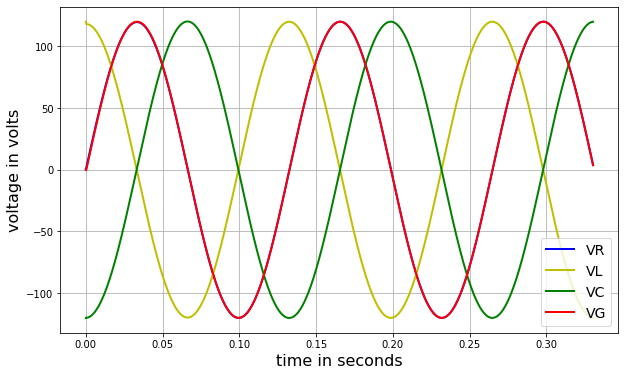

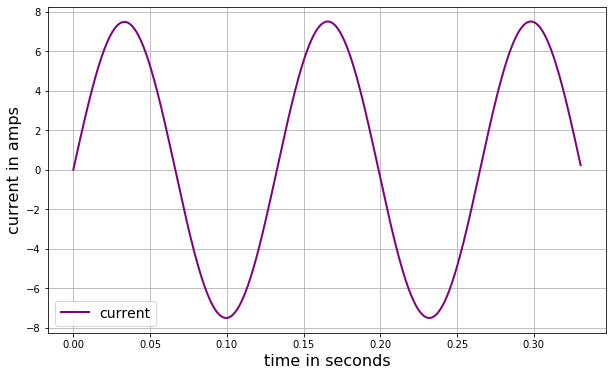

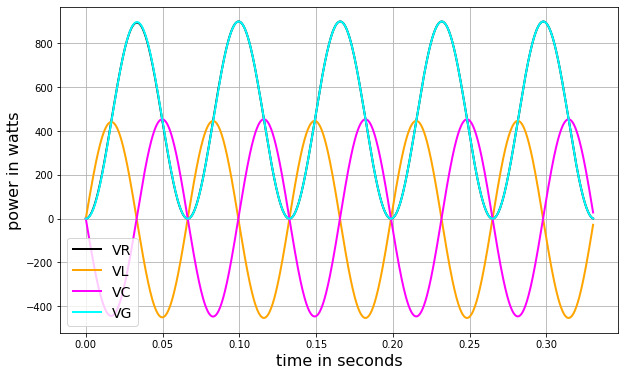

In [4]:
rlc = Circuit(XC = XC_resonance)
rlc.solve_circuit() 
print('energy dissipated by resistor:', rlc.calc_energy_dissipated())

fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax.plot(rlc.timesteps, rlc.VRarray, lw = 2, color = 'b', label = 'VR')
ax.plot(rlc.timesteps, rlc.VLarray, lw = 2, color = 'y', label = 'VL')
ax.plot(rlc.timesteps, rlc.VCarray, lw = 2, color = 'g', label = 'VC')
ax.plot(rlc.timesteps, rlc.VGarray, lw = 2, color = 'r', label = 'VG')
ax.set_xlabel('time in seconds', fontsize = 16)
ax.set_ylabel('voltage in volts', fontsize = 16)
ax.grid()
leg = ax.legend(fontsize = 14)

fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax.plot(rlc.timesteps, rlc.Iarray, lw = 2, color = 'purple', label = 'current')
ax.set_xlabel('time in seconds', fontsize = 16)
ax.set_ylabel('current in amps', fontsize = 16)
ax.grid()
leg = ax.legend(fontsize = 14)

fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax.plot(rlc.timesteps, rlc.PRarray, lw = 2, color = 'black', label = 'VR')
ax.plot(rlc.timesteps, rlc.PLarray, lw = 2, color = 'orange', label = 'VL')
ax.plot(rlc.timesteps, rlc.PCarray, lw = 2, color = 'magenta', label = 'VC')
ax.plot(rlc.timesteps, rlc.PGarray, lw = 2, color = 'cyan', label = 'VG')
ax.set_xlabel('time in seconds', fontsize = 16)
ax.set_ylabel('power in watts', fontsize = 16)
ax.grid()
leg = ax.legend(fontsize = 14)


## Current lags 30 degrees

energy dissipated by resistor: 112.61191289251727


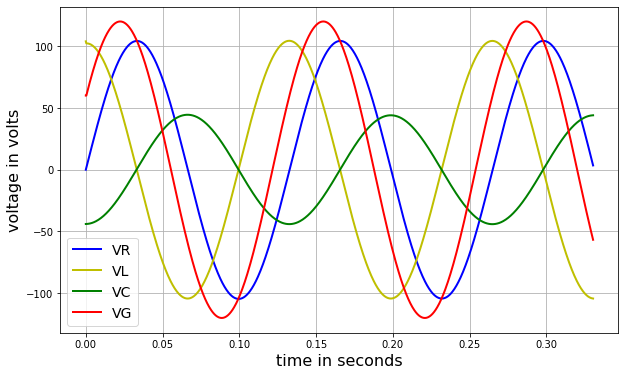

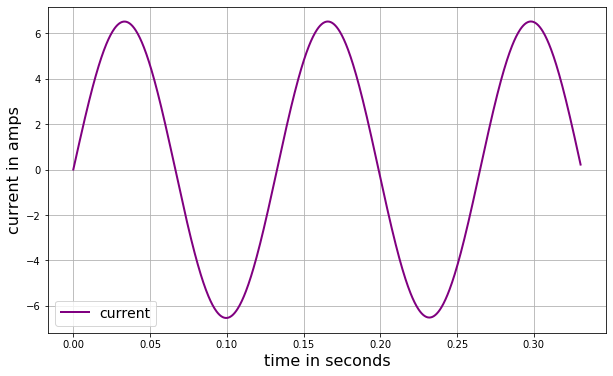

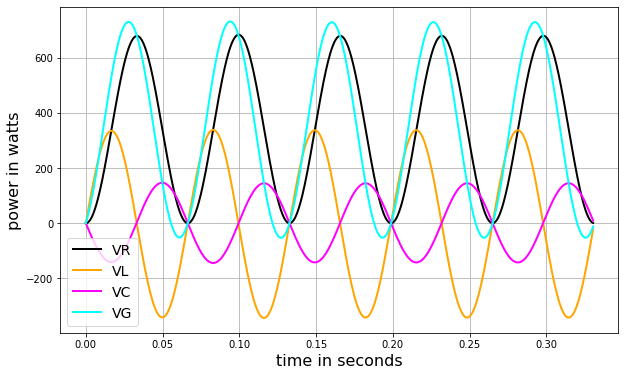

In [5]:
rlc = Circuit(XC = XC_lag)
rlc.solve_circuit() 
print('energy dissipated by resistor:', rlc.calc_energy_dissipated())

fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax.plot(rlc.timesteps, rlc.VRarray, lw = 2, color = 'b', label = 'VR')
ax.plot(rlc.timesteps, rlc.VLarray, lw = 2, color = 'y', label = 'VL')
ax.plot(rlc.timesteps, rlc.VCarray, lw = 2, color = 'g', label = 'VC')
ax.plot(rlc.timesteps, rlc.VGarray, lw = 2, color = 'r', label = 'VG')
ax.set_xlabel('time in seconds', fontsize = 16)
ax.set_ylabel('voltage in volts', fontsize = 16)
ax.grid()
leg = ax.legend(fontsize = 14)

fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax.plot(rlc.timesteps, rlc.Iarray, lw = 2, color = 'purple', label = 'current')
ax.set_xlabel('time in seconds', fontsize = 16)
ax.set_ylabel('current in amps', fontsize = 16)
ax.grid()
leg = ax.legend(fontsize = 14)

fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax.plot(rlc.timesteps, rlc.PRarray, lw = 2, color = 'black', label = 'VR')
ax.plot(rlc.timesteps, rlc.PLarray, lw = 2, color = 'orange', label = 'VL')
ax.plot(rlc.timesteps, rlc.PCarray, lw = 2, color = 'magenta', label = 'VC')
ax.plot(rlc.timesteps, rlc.PGarray, lw = 2, color = 'cyan', label = 'VG')
ax.set_xlabel('time in seconds', fontsize = 16)
ax.set_ylabel('power in watts', fontsize = 16)
ax.grid()
leg = ax.legend(fontsize = 14)


## Current lead 30 degrees

energy dissipated by resistor: 110.79942297585386


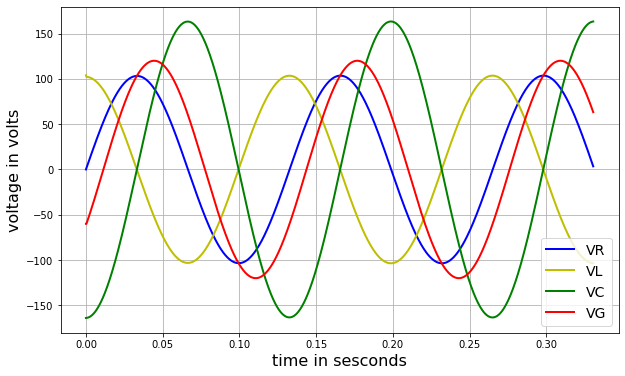

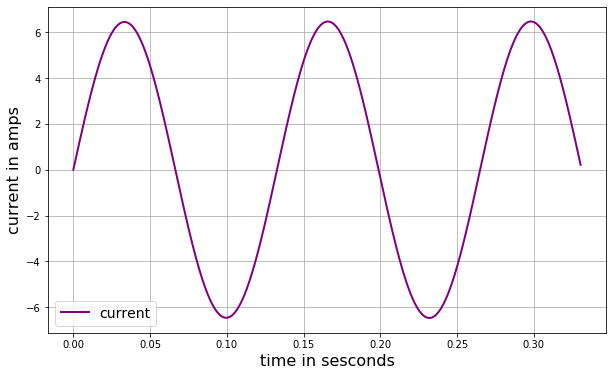

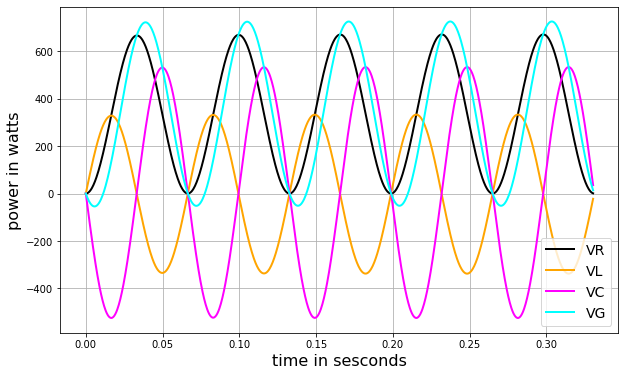

In [6]:
rlc = Circuit(XC = XC_lead)
rlc.solve_circuit() 
print('energy dissipated by resistor:', rlc.calc_energy_dissipated())

fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax.plot(rlc.timesteps, rlc.VRarray, lw = 2, color = 'b', label = 'VR')
ax.plot(rlc.timesteps, rlc.VLarray, lw = 2, color = 'y', label = 'VL')
ax.plot(rlc.timesteps, rlc.VCarray, lw = 2, color = 'g', label = 'VC')
ax.plot(rlc.timesteps, rlc.VGarray, lw = 2, color = 'r', label = 'VG')
ax.set_xlabel('time in sesconds', fontsize = 16)
ax.set_ylabel('voltage in volts', fontsize = 16)
ax.grid()
leg = ax.legend(fontsize = 14)

fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax.plot(rlc.timesteps, rlc.Iarray, lw = 2, color = 'purple', label = 'current')
ax.set_xlabel('time in sesconds', fontsize = 16)
ax.set_ylabel('current in amps', fontsize = 16)
ax.grid()
leg = ax.legend(fontsize = 14)

fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax.plot(rlc.timesteps, rlc.PRarray, lw = 2, color = 'black', label = 'VR')
ax.plot(rlc.timesteps, rlc.PLarray, lw = 2, color = 'orange', label = 'VL')
ax.plot(rlc.timesteps, rlc.PCarray, lw = 2, color = 'magenta', label = 'VC')
ax.plot(rlc.timesteps, rlc.PGarray, lw = 2, color = 'cyan', label = 'VG')
ax.set_xlabel('time in sesconds', fontsize = 16)
ax.set_ylabel('power in watts', fontsize = 16)
ax.grid()
leg = ax.legend(fontsize = 14)


## Bode plots of circuit in resonance

In [7]:
V0 = 120

L = 0.337
R = 16

omega = R / L #resonant frequency

XL = omega * L

XC_resonance = XL

C = 1 / omega / XC_resonance

class bode_plot():
    '''for each frequency,
    calculate max voltage of each circuit component divided by max generator voltage and energy dissipated'''
    def __init__(self, freq_low, freq_high, num_steps = 1000):
        
        self.num_steps = num_steps
        self.freq_low = freq_low
        self.freq_high = freq_high
        
        # define an array of frequencies
        self.frequencies = np.logspace(np.log10(self.freq_low), np.log10(self.freq_high), self.num_steps)   
        self.shape = self.frequencies.size
        
        # voltage of inductor, capacitor, resistor
        self.VLarray, self.VCarray, self.VRarray = np.zeros(self.shape), np.zeros(self.shape), np.zeros(self.shape)
        # energy dissipated by resistor
        self.ERarray = np.zeros(self.shape)
        
    def max_voltage(self):
        
        frequencies = self.frequencies
        i = 0
        
        for freq in frequencies:
            
            # solve the circuit
            rlc = Circuit(XL = freq * L, XC = 1 / freq / C, omega = freq)
            rlc.solve_circuit() 
            
            self.VLarray[i] = np.max(abs(rlc.VLarray)) / V0 # ratio of max inductor voltage to generator voltage
            self.VCarray[i] = np.max(abs(rlc.VCarray)) / V0 # ............. capacitor ..........................
            self.VRarray[i] = np.max(abs(rlc.VRarray)) / V0 # .............. resistor ..........................
            
            i += 1
            
    def calc_energy_dissipated(self):
        
        frequencies = self.frequencies
        i = 0
        
        for freq in frequencies:
            
            # solve the circuit
            rlc = Circuit(XL = freq * L, XC = 1 / freq / C, omega = freq)
            rlc.solve_circuit() 
            
            # energy
            self.ERarray[i] = rlc.calc_energy_dissipated()
            
            i += 1


max total energy:  158.08804947765447 at frequency:  41.83566373751566


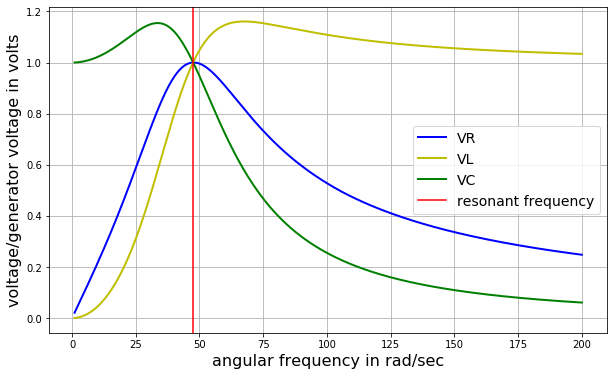

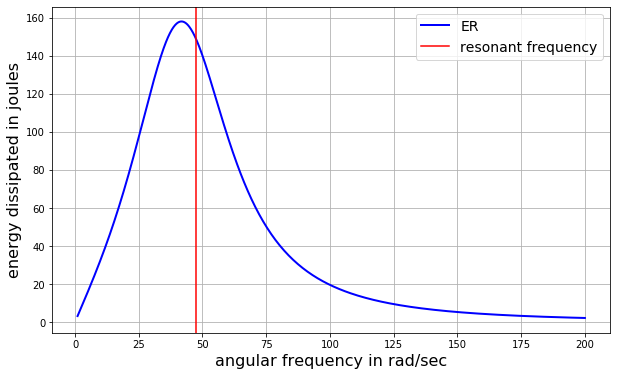

In [8]:
bode = bode_plot(freq_low = 1, freq_high = 200)
bode.max_voltage()
bode.calc_energy_dissipated()

fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax.plot(bode.frequencies, bode.VRarray, lw = 2, color = 'b', label = 'VR')
ax.plot(bode.frequencies, bode.VLarray, lw = 2, color = 'y', label = 'VL')
ax.plot(bode.frequencies, bode.VCarray, lw = 2, color = 'g', label = 'VC')
plt.axvline(x = 1 / np.sqrt(L / XC_resonance / omega), color='r', label = 'resonant frequency')
ax.set_xlabel('angular frequency in rad/sec', fontsize = 16)
ax.set_ylabel('voltage/generator voltage in volts', fontsize = 16)
ax.grid()
leg = ax.legend(fontsize = 14)

fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax.plot(bode.frequencies, bode.ERarray, lw = 2, color = 'b', label = 'ER')
plt.axvline(x = 1 / np.sqrt(L / XC_resonance / omega), color = 'r', label = 'resonant frequency')
ax.set_xlabel('angular frequency in rad/sec', fontsize = 16)
ax.set_ylabel('energy dissipated in joules', fontsize = 16)
ax.grid()
leg = ax.legend(fontsize = 14)

print('max total energy: ', np.max(bode.ERarray), 'at frequency: ', bode.frequencies[np.argmax(bode.ERarray)])
